In [2]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
%matplotlib inline

In [3]:
class Magnet(object):
    def __init__(self, theta_init, radius, charge):
        self.theta_init = theta_init
        self.radius = radius
        self.charge = charge
        self.theta = 0
        self.updateP()
        
    def updateP(self):
        self.p = self.pos()
    
    def pos(self):
        return np.array([np.cos(self.theta_init+self.theta) * self.radius,
                np.sin(self.theta_init + self.theta) * self.radius])
    
    def force(self, stator_magnet):
        # self is in the rotor
        # stator_magnet is magnet in stator
        charge = self.charge * stator_magnet.charge
        
        R = self.p
        R = R / np.linalg.norm(R)
        
        F = stator_magnet.p - self.p
        F_norm = np.linalg.norm(F)
        F /= F_norm
        
        force = - 5 * charge * np.cross(R, F) / (F_norm ** 2)
        return force
    
    def render(self, img):
        p = self.pos()
        height, width, _ = img.shape
        intensity = abs(self.charge) * 255
        intensity = max(0, min(255, intensity))
        intensity = int(intensity)
        c = (intensity, 0, 0) if self.charge < 0 else (0, 0, intensity)
        img = cv2.circle(img, (int(p[0]+width/2), int(p[1]+height/2)), 22, (255, 255, 255), 2)
        return cv2.circle(img, (int(p[0]+width/2), int(p[1]+height/2)), 20, c, -1)

class Motor(object):
    def __init__(self, stator_radius,
                       rotor_radius,
                       decay,
                       rotor_num,
                       stator_num):
        self.stator_radius = stator_radius
        self.rotor_radius = rotor_radius
        self.decay = decay
        self.rotor_num = rotor_num
        self.stator_num = stator_num
        
        self.theta = 0
        self.vel = 0
        self.target_angle = 0
        
        charge_fn = lambda i: 1 if i%2 == 0 else -1
        
        self.rotor = [Magnet(i * 2 * np.pi / rotor_num, rotor_radius, charge_fn(i))
                      for i in range(rotor_num)]
        self.stator = [Magnet(i * 2 * np.pi / stator_num, stator_radius, charge_fn(i))
                      for i in range(stator_num)]
        
    def step(self, stator_state, steps, render=False):
        theta_init = self.theta
        vel_init = self.vel
        
        thetas = [self.theta]
        vels = [self.vel]
        
        for i in range(steps):
            
            for s, charge in zip(self.stator, stator_state):
                s.charge = charge
            
            for r in self.rotor:
                r.theta = self.theta
                r.updateP()
                for s in self.stator:
                    force = r.force(s)
                    self.vel += force
            self.theta += self.vel
            thetas += [self.theta]
            vels += [self.vel]
            self.vel *= self.decay
            
            if render: self.render()
                    
        dtheta = self.theta - theta_init
        dvel = self.vel - vel_init
        return (thetas, vels, dtheta, dvel)
    
    def render(self):
        width, height = 400, 400
        
        img = np.zeros((height, width, 3), dtype=np.uint8)
        
        avg_radius = int((self.rotor_radius + self.stator_radius) / 2)
        cv2.circle(img, (200, 200), avg_radius, (255,255,255), 1) #(BGR)
        
        # draw the angle of the motor
        angle_pt = (int(200 + avg_radius * np.cos(self.theta)), 
                    int(200 + avg_radius * np.sin(self.theta)))
        cv2.line(img, (200, 200), 
                      angle_pt, (255, 255, 255), 2)
        
        if self.target_angle:
            target_pt = (int(200 + avg_radius * np.cos(self.target_angle)), 
                         int(200 + avg_radius * np.sin(self.target_angle)))
            cv2.line(img, (200, 200), 
                      target_pt, (0, 255, 0), 2)
        
        for s in self.stator:
            img = s.render(img)
            
        for r in self.rotor:
            img = r.render(img)
            
        img = np.flip(img, axis=0)
        cv2.imshow("BLDC", img)
        cv2.waitKey(1)
        
motor = Motor(stator_radius=120,
              rotor_radius=60,
              decay=0.95,
              rotor_num=2,
              stator_num=3
             )

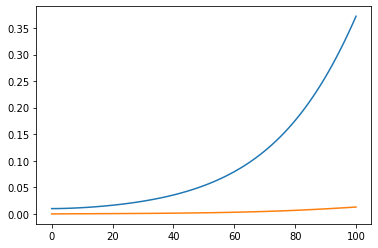

0.012258972772880431


In [4]:
motor.theta = 0.01
motor.vel = 0
motor.target_angle = np.pi /2

thetas, vels, dtheta, dvel = motor.step([1, 1, 1], 100, True)
fig = plt.plot(thetas)
fig = plt.plot(vels)
plt.show()

print(dvel)

# Explore possible phases for 3 stator magnet

<img src="BLDC.png">

In [25]:
states = [[1, 0, -1],
          [0, 1, -1],
          [-1, 1, 0],
          [-1, 0, 1],
          [0, -1, 1],
          [1, -1, 0]]

state_angles = [np.pi * 7 / 6,
              np.pi * 9 / 6,
              np.pi * 11 / 6,
              np.pi * 13 / 6,
              np.pi * 15 / 6,
              np.pi * 17 / 6]

In [27]:
# 30 degrees alignment
motor.theta = 0
motor.target_angle = state_angles[0]
_, _, _, _ = motor.step(states[0], 200, True)

In [28]:
# 90 degrees alignment
motor.target_angle = state_angles[1]
_, _, _, _ = motor.step(states[1], 200, True)

In [29]:
# 150 degrees alignment
motor.target_angle = state_angles[2]
_, _, _, _ = motor.step(states[2], 200, True)

In [30]:
# 210 degrees alignment
motor.target_angle = state_angles[3]
_, _, _, _ = motor.step(states[3], 200, True)

In [31]:
# 270 degrees alignment
motor.target_angle = state_angles[4]
_, _, _, _ = motor.step(states[4], 200, True)

In [32]:
# 330 degrees alignment
motor.target_angle = state_angles[5]
_, _, _, _ = motor.step(states[5], 200, True)

In [33]:
for s, a in zip(states, state_angles):
    motor.target_angle = a
    motor.step(s, 200, True)

In [41]:
for i in range(20):
    motor.target_angle = state_angles[i%6]
    motor.step(states[i%6], 42, True)

In [40]:
# Reverse the order you energize reverses the motor

for i in reversed(range(20)):
    motor.target_angle = state_angles[i%6]
    motor.step(states[i%6], 50, True)

In [44]:
# Try to reach an angle by driving forward or backward
motor.theta = 0
motor.target_angle = 2 * np.pi / 3

i = 0
for _ in range(20):
    if motor.theta < motor.target_angle:
        i += 1
    else:
        i -= 1
    
    motor.step(states[i%6], 70, True)

In [45]:
from time import sleep

def minAngle(x, y):
    tau = 2*np.pi
    a = (x - y) % tau
    b = (y - x) % tau
    return -a if a < b else b

for _ in range(10):
    motor.theta = np.random.random() * 2 * np.pi
    motor.target_angle = np.random.random() * 2 * np.pi
    
    for _ in range(10):
        for r in motor.rotor:
            r.theta = motor.theta
        motor.render()
        motor.theta += minAngle(motor.theta, motor.target_angle) / 4
        sleep(0.1)

# Q Learning Training

https://www.geeksforgeeks.org/q-learning-in-python/

In [49]:
import itertools 
import matplotlib 
import matplotlib.style 
import numpy as np 
import pandas as pd 
import sys
from collections import defaultdict 
from IPython.display import clear_ou

matplotlib.style.use('ggplot')

class MotorEnv():
    def __init__(self):
        self.motor = Motor(stator_radius=120,
                  rotor_radius=80,
                  decay=0.95,
                  rotor_num=2,
                  stator_num=3
                 )
        
        self.actions = len(states)
        self.render = False
        
        self.episode_steps = 100
        self.steps = 0

    def states(self):
        return dict(type='float', shape=(1,))
    
    def getState(self):
        t1 = self.motor.theta
        t2 = self.motor.target_angle
        motor_angle = (np.round(t1 % (2 * np.pi) / (2 * np.pi) * 20) / 20)
        target_angle = (np.round(t2 % (2 * np.pi) / (2 * np.pi) * 20) / 20)
        
        #ma = minAngle(self.motor.theta,
                      #self.motor.target_angle)
        #ma = np.round((ma / np.pi) * 10) / 10
        return (motor_angle, self.motor.direction)

    def reset(self):
        self.steps = 0
        self.motor.direction = np.random.choice([-1, 0, 1])
        self.motor.target_angle = np.pi
        self.motor.theta = np.random.random() * 2 * np.pi - np.pi
        self.motor.vel = np.random.randn() * .01
        return self.getState()

    def step(self, actions):
        
        motor_states = states[actions]
        thetas, vels, dtheta, dvel = self.motor.step(motor_states, 1, self.render)
        
        self.steps += 1
        terminal = True if self.steps >= self.episode_steps else False
        
        reward = self.motor.direction * dvel * 10
        if self.motor.direction == 0:
            reward = -np.abs(self.motor.vel)
            
        #reward = -np.abs(minAngle(self.motor.theta, self.motor.target_angle))
        #reward = -np.abs(self.motor.theta) # dvel * 10
        
        return self.getState(), reward, terminal

def createEpsilonGreedyPolicy(Q, epsilon, num_actions): 
    """ 
    Creates an epsilon-greedy policy based 
    on a given Q-function and epsilon. 
    
    Returns a function that takes the state 
    as an input and returns the probabilities 
    for each action in the form of a numpy array  
    of length of the action space(set of possible actions). 
    """
    def policyFunction(state): 
   
        Action_probabilities = np.ones(num_actions, 
                dtype = float) * epsilon / num_actions
        best_action = np.argmax(Q[state]) 
        Action_probabilities[best_action] += (1.0 - epsilon) 
        return Action_probabilities
    
    return policyFunction

def qLearning(env, Q, num_episodes, episode_steps, discount_factor = 0.9, 
                            alpha = 0.3, epsilon = 0.1): 
    """ 
    Q-Learning algorithm: Off-policy TD control. 
    Finds the optimal greedy policy while improving 
    following an epsilon-greedy policy"""
    
    env.render = False
    env.episode_steps = episode_steps

    rewards = []

    policy = createEpsilonGreedyPolicy(Q, epsilon, env.actions)
       
    for ith_episode in range(num_episodes): 
        
        state = env.reset()
        
        avg_reward = 0
        
        for t in itertools.count():
            action_probabilities = policy(state)
   
            action = np.random.choice(np.arange( 
                      len(action_probabilities)), 
                       p = action_probabilities)
   
            next_state, reward, done = env.step(action)
   
            avg_reward += reward
               
            # TD Update
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
   
            # done is True if episode terminated    
            if done:
                break
                   
            state = next_state
            
        avg_reward /= 1 if t == 0 else t
        rewards += [avg_reward]
        
        # print Q values
        if ith_episode % 50 == 0:
            clear_output(wait=True)
            #print("episode: ", ith_episode)
            #for state in Q:
            #    fig = plt.plot(Q[state])
                
            plt.plot(rewards)
            plt.show()
       
    return Q, rewards


env = MotorEnv()
Q = defaultdict(lambda: np.zeros(env.actions))

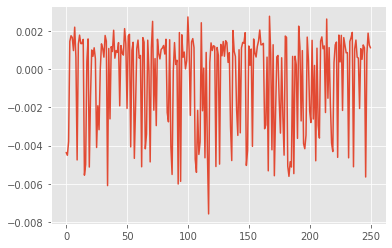

In [68]:
# Train
Q, rewards = qLearning(env, Q, 300, 200, discount_factor=0.8, alpha=0.1, epsilon=0.2)

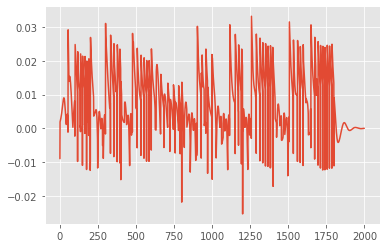

In [73]:
# Evaluate the best policy

def evaluate(env, Q, num_episodes, episode_steps, epsilon = 0.0): 
    
    env.render = True
    env.episode_steps = episode_steps
    env.motor.decay = 0.95
    
    rewards = []
    policy = createEpsilonGreedyPolicy(Q, epsilon, env.actions) 
    
    for ith_episode in range(num_episodes):
        
        state = env.reset()
        env.motor.target_angle = np.random.random() * 2 * np.pi
        
        for t in itertools.count():
            env.motor.direction = np.sign(minAngle(env.motor.theta,
                                                   env.motor.target_angle))
            #env.motor.direction = 0
            
            action_probabilities = policy(state) 
            action = np.random.choice(np.arange( 
                      len(action_probabilities)), 
                       p = action_probabilities) 
   
            next_state, reward, done = env.step(action) 
            rewards += [reward]
            
            if done:
                break
                   
            state = next_state
       
    return rewards

rewards = evaluate(env, Q, 10, 200, epsilon = 0.0)
plt.plot(rewards)

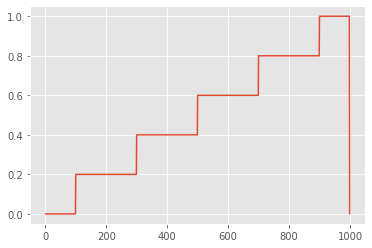

In [74]:
ts = []
for t in np.linspace(0, 2 * np.pi, 1000):
    ts += [np.round(t % (2 * np.pi) / (2 * np.pi) * 5) / 5]
    
plt.plot(ts)

# Evolution Strategies Training

In [228]:
def state(motor):
    return motor.theta % (2 * np.pi)

def stator_state(W, motor):
    t = state(motor)
    stators = motor.stator_num
    stator_state = np.zeros((stators))
    frac = 1 / stators
    for i, r in enumerate(W):
        stator_state[i] = frac * np.sin(t*r[0] + r[1])
    return stator_state

def plot_stator_state(W):
    for stator in range(W.shape[0]):
        pts = []
        for t in np.linspace(0, 2 * np.pi, 50)[:-1]:
            motor.theta = t
            pts += [[t, stator_state(W, motor)[stator]]]

        pts = np.array(pts)
        fig = plt.plot(pts[:,0], pts[:,1])

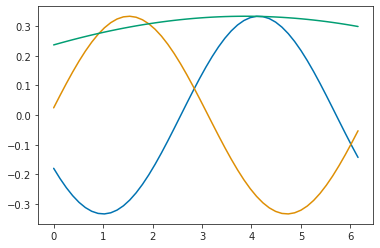

In [229]:
motor = Motor(stator_radius=120,
              rotor_radius=80,
              decay=0.995,
              rotor_num=2,
              stator_num=3
             )

W = np.random.randn(motor.stator_num, 2) # stators x 2 params each

plot_stator_state(W)

900


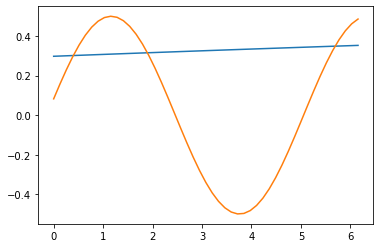

In [413]:
avg_dvels = []

# train
for i in range(1000):
    if i % 100 == 0:
        clear_output(wait=True)
        print(i)
        #plt.plot(avg_dvels)
        plot_stator_state(W)
        plt.show()
    
    theta_init = np.random.random() * 2 * np.pi
    vel_init = np.random.randn() * .01
    
    motor.theta = theta_init
    motor.vel = vel_init
    _, _, _, dvel_init = motor.step(stator_state(W, motor), 1, False)
    
    avg_dvels += [dvel_init]
    
    W_update = np.zeros_like(W)
    
    for j in range(50):
        Wd = np.random.randn(W.shape[0], W.shape[1])
        bd = np.random.randn(b.shape[0])
        motor.theta = theta_init
        motor.vel = vel_init
        _, _, dtheta, dvel = motor.step(stator_state(W+Wd,
                                                     motor), 1, False)
        
        W_update += Wd * (dvel - dvel_init)
    
    W += 1 * W_update

In [416]:
# evaluate
for k in range(1):
    theta_init = np.random.random() * 2 * np.pi
    vel_init = 0
    motor.theta = theta_init
    motor.vel = vel_init

    for i in range(1000):
        _, _, _, dvel_init = motor.step(stator_state(w, motor), 1, True)

# Pick the best weights Training

In [468]:
best_dvel = 0
best_W = np.random.randn(motor.stator_num, 2)
dvels = []

In [471]:
for i in range(1000):
    W = 2 * np.random.randn(best_W.shape[0], best_W.shape[1])
    
    avg_dvel = 0
    
    for j in range(10):
        motor.theta = np.random.random() * 2 * np.pi
        motor.vel = 0 #np.random.randn() * .1
        _, _, _, dvel = motor.step(stator_state(W, motor), 10, False)
        avg_dvel += dvel
    
    if avg_dvel > best_dvel:
        print("new best: ", avg_dvel)
        best_dvel = avg_dvel
        best_W = W
        dvels += [avg_dvel]
        
        clear_output(wait=True)
        #print(i)
        plot_stator_state(W)
        plt.show()

In [470]:
# evaluate
for k in range(1):
    theta_init = np.random.random() * 2 * np.pi
    vel_init = 0
    motor.theta = theta_init
    motor.vel = vel_init

    for i in range(10000):
        _, _, _, dvel_init = motor.step(stator_state(best_W, motor), 1, True)

KeyboardInterrupt: 

# Training

source: https://tensorforce.readthedocs.io/en/latest/basics/getting-started.html

In [169]:
from tensorforce.environments import Environment
from tensorforce.agents import Agent
from tensorforce.execution import Runner
from IPython.display import clear_output

In [176]:
class MotorEnv(Environment):
    def __init__(self):
        super().__init__()
        self.motor = Motor(stator_radius=120,
                  rotor_radius=80,
                  decay=0.995,
                  rotor_num=2,
                  stator_num=3
                 )
        self.num_actions = 6
        self.render = False
        self.episode_steps = 100

    def states(self):
        return dict(type='float', shape=(1,))

    def actions(self):
        return dict(type='int', num_values=6)
    
    # Optional
    def close(self):
        super().close()

    def reset(self):
        self.motor.theta = np.random.random() * 2 * np.pi - np.pi
        self.motor.vel = np.random.randn() * .05
        self.motor.steps = 0
        return np.array([self.motor.theta % 2*np.pi])

    def execute(self, actions):
        stator_num = self.motor.stator_num
        
        motor_states = states[actions]
        thetas, vels, dtheta, dvel = self.motor.step(motor_states, 10, self.render)
        next_state = np.array([self.motor.theta % 2*np.pi])
        
        self.motor.steps += 1
        terminal = True if self.motor.steps >= self.episode_steps else False
        reward = dvel * 10 #-np.abs(self.motor.theta)
        return next_state, terminal, reward
    
env = MotorEnv()

#agent = Agent.create(
#    agent='ppo', environment=env, batch_size=10, learning_rate=1e-3, max_episode_timesteps=1
#)

agent = Agent.create(
    agent='tensorforce', environment=env, update=64,
    objective='policy_gradient', reward_estimation=dict(horizon=20),
    max_episode_timesteps=100, exploration=.2
)

runner = Runner(
    agent=agent,
    environment=env
)

clear_output(wait=True)
env.episode_steps = 5
runner.run(num_episodes=100)



Episodes:   0%|          | 0/100 [00:00, reward=0.00, ts/ep=0, sec/ep=0.00, ms/ts=0.0, agent=0.0%]

Episodes:   1%|          | 1/100 [00:01, reward=-0.27, ts/ep=5, sec/ep=1.98, ms/ts=396.5, agent=98.9%]

Episodes:   4%|▍         | 4/100 [00:02, reward=-0.73, ts/ep=5, sec/ep=0.04, ms/ts=7.1, agent=43.3%]  

Episodes:   7%|▋         | 7/100 [00:02, reward=-0.27, ts/ep=5, sec/ep=0.04, ms/ts=7.5, agent=43.0%]

Episodes:  10%|█         | 10/100 [00:02, reward=-0.26, ts/ep=5, sec/ep=0.04, ms/ts=7.2, agent=43.6%]

Episodes:  13%|█▎        | 13/100 [00:02, reward=0.54, ts/ep=5, sec/ep=0.03, ms/ts=7.0, agent=42.6%] 

Episodes:  16%|█▌        | 16/100 [00:02, reward=0.10, ts/ep=5, sec/ep=0.04, ms/ts=7.2, agent=44.2%]

Episodes:  19%|█▉        | 19/100 [00:02, reward=-0.13, ts/ep=5, sec/ep=0.04, ms/ts=7.1, agent=43.1%]

Episodes:  22%|██▏       | 22/100 [00:02, reward=-0.05, ts/ep=5, sec/ep=0.03, ms/ts=6.9, agent=42.0%]

Episodes:  25%|██▌       | 25/100 [00:02, reward=-0.67, ts/ep=5, sec/ep=0.

In [177]:
env.render = True
env.episode_steps = 10
runner.run(num_episodes=10, evaluation=True)

Episodes: 100%|██████████| 100/100 [00:16, reward=-0.32, ts/ep=5, sec/ep=0.03, ms/ts=6.8, agent=40.5%]


Episodes:   0%|          | 0/10 [00:00, reward=0.00, ts/ep=0, sec/ep=0.00, ms/ts=0.0, agent=0.0%]

Episodes:  10%|█         | 1/10 [00:01, reward=0.13, ts/ep=10, sec/ep=1.08, ms/ts=107.8, agent=39.2%]

Episodes:  20%|██        | 2/10 [00:01, reward=-0.56, ts/ep=10, sec/ep=0.73, ms/ts=72.9, agent=2.1%] 

Episodes:  30%|███       | 3/10 [00:02, reward=-0.12, ts/ep=10, sec/ep=0.74, ms/ts=74.2, agent=2.5%]

Episodes:  40%|████      | 4/10 [00:03, reward=-0.08, ts/ep=10, sec/ep=0.73, ms/ts=73.4, agent=2.4%]

Episodes:  50%|█████     | 5/10 [00:04, reward=0.02, ts/ep=10, sec/ep=0.73, ms/ts=73.3, agent=2.4%] 

Episodes:  60%|██████    | 6/10 [00:04, reward=1.24, ts/ep=10, sec/ep=0.69, ms/ts=69.5, agent=2.6%]

Episodes:  70%|███████   | 7/10 [00:05, reward=-0.46, ts/ep=10, sec/ep=0.71, ms/ts=71.1, agent=2.4%]

Episodes:  80%|████████  | 8/10 [00:06, reward=0.24, ts/ep=10, sec/ep=0.72, ms/ts

In [10]:
runner.close()

Episodes: 100%|██████████| 30/30 [00:29, reward=1.61, ts/ep=10, sec/ep=0.32, ms/ts=32.5, agent=4.7%]


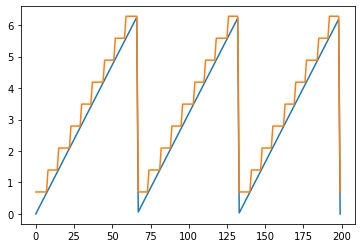

In [175]:
t = np.linspace(-2*np.pi, 4 * np.pi, 200)
t = t % (2*np.pi)
t2 = [np.digitize(h, np.linspace(0, 2*np.pi, 10)) for h in t]
t2 /= np.max(t2)
t2 *= 2*np.pi
fig = plt.plot(t)
fig = plt.plot(t2)